In [35]:
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import multiprocessing as mp
import pandas as pd
import geopandas as gpd
import gtfs_kit as gk
import numpy as np

from shapely import geometry


%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.0.1'

In [13]:
data_dir = '../data/'

### Import networks

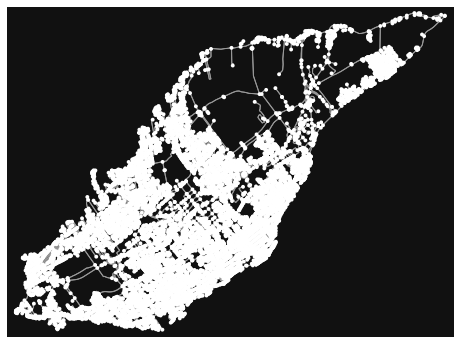

CPU times: user 12.6 s, sys: 180 ms, total: 12.8 s
Wall time: 12.6 s


In [14]:
%%time

G = ox.graph_from_place('Laval, Canada', network_type='drive_service')
fig, ax = ox.plot_graph(G)

## Import GTFS

In [15]:
feed = gk.read_feed(data_dir +'gtfs.zip', dist_units='m')

In [16]:
# Get all terminus (stop_sequence == 1) 
terminus_id = list(feed.stop_times[feed.stop_times['stop_sequence'] == 1]['stop_id'].unique())

terminus = feed.stops[feed.stops['stop_id'].isin(terminus_id)]
terminus.head()

,stop_id,stop_code,stop_name,stop_lon,stop_lat,location_type,stop_display,stop_abribus
0,AOUT19CP40002,40002,Terminus Henri-Bourassa Quai:4 [40002],-73.66720,45.555819,0,0,0
1,AOUT19CP40031,40031,Terminus Henri-Bourassa Quai:9 [40031],-73.66993,45.555747,0,0,0
2,AOUT19CP40052,40052,Terminus Henri-Bourassa Quai:9 [40052],-73.66993,45.555747,0,0,0
3,AOUT19CP40055,40055,Terminus Henri-Bourassa Quai:9 [40055],-73.66993,45.555747,0,0,0
6,AOUT19CP40144,40144,Métro Côte-Vertu Quai:20 [40144],-73.68270,45.513237,0,0,0


## Routing

### Grid of origines

In [17]:
## Get a gridmesh of points in laval
city = ox.geocode_to_gdf(['Laval, Canada'])
city_proj = ox.project_gdf(city)
laval = city_proj['geometry'][0]
box = laval.bounds
n = 50
x = np.linspace(box[0],box[2],n)
y = np.linspace(box[1],box[3],n)
xx, yy = np.meshgrid(x,y)

points = [geometry.Point([lng, lat]) for lng, lat in zip(xx.flatten(),yy.flatten()) if laval.contains(geometry.Point([lng, lat]))]

In [18]:
# convert points in lngs and lons cuz ox
points = gpd.GeoDataFrame(points, columns=['geometry'])
points = points.set_crs(epsg=32618)
points = points.to_crs(epsg=4326)

### Sets of nearest nodes

In [19]:
# list of lats and lngs
lngs = [point.x for point in points['geometry']]
lats = [point.y for point in points['geometry']]

# find the nearest node to the center
grid_nodes = ox.get_nearest_nodes(G, lngs, lats, method='kdtree')

In [20]:
# find the nearest nodes to the set terminus
terminus_nodes = ox.get_nearest_nodes(G, terminus['stop_lon'], terminus['stop_lat'])

### Multiprocessing of shortest paths

In [21]:
cpus = mp.cpu_count()

In [22]:
def shortest_path(G, orig, dest):
    try:
        return ox.shortest_path(G, orig, dest, weight='length')
    except:
        # for unsolvable routes (due to directed graph perimeter effects)
        return None

In [23]:
# create iterable parameters (O-D pairs) for each function run
no, nd = np.meshgrid(grid_nodes,terminus_nodes)

params = ((G, orig, dest) for orig, dest in zip(no.flatten(), nd.flatten()))

In [24]:
# create a pool of worker processes
pool = mp.Pool(cpus)

# map the function/parameters to the worker processes
sma = pool.starmap_async(shortest_path, params)

In [25]:
%%time
# get the results, close the pool, wait for worker processes to all exit
routes = sma.get()
pool.close()
pool.join()

CPU times: user 4.4 s, sys: 168 ms, total: 4.57 s
Wall time: 15min 8s


In [27]:
# how many total results did we get
print(len(routes))

# and how many were solvable paths
routes_valid = [r for r in routes if r is not None]
print(len(routes_valid))

103000
102800


In [41]:
routes_df = pd.DataFrame(zip(no.flatten(),nd.flatten(),routes),columns = ['origin','destination','route'])

In [47]:
routes_df['length'] = routes_df['route'].apply(lambda route: sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length')) if route is not None else 0.0)

In [53]:
points['grid_node'] = grid_nodes

In [56]:
routes_df = routes_df.merge(points, left_on='origin', right_on='grid_node')

In [63]:
routes_df['hash'] = routes_df['geometry'].apply(lambda point: hash(tuple(point.coords)))

In [69]:
pts_length = routes_df.groupby('hash').agg({'geometry':'first','length':'mean'})

In [70]:
gpd.GeoDataFrame(pts_length).to_file(data_dir +'points_dist.geojson', driver='GeoJSON')